<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
source_folder = '/content/drive/MyDrive/TASI/Random Search/DataImbalance'
destination_folder = '/content/drive/MyDrive/TASI/Best Model/RandomSearch'

In [24]:
%cd //content/drive/MyDrive/TASI/Random Search/DataImbalance

/content/drive/MyDrive/TASI/Random Search/DataImbalance


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install git+https://github.com/pytorch/text.git@v0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/text.git (to revision v0.10.0) to /tmp/pip-req-build-xqh2mhpl
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/text.git /tmp/pip-req-build-xqh2mhpl
  Running command git checkout -q 4da1de36247aa06622088e78508e0e38a4392e38
  Resolved h

In [25]:
import pandas as pd
import numpy as np
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [26]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # jika menggunakan multiple GPUs
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

In [29]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv',
                                           format='csv', fields=fields, skip_header=True)


In [30]:
# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=32, device=device, train=False, shuffle=False, sort=False)

In [31]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [32]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, epoch_list):
    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'epoch_list': epoch_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['epoch_list']

## Training and Validation

In [33]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=9,
          eval_every=1,
          file_path=destination_folder,
          best_valid_loss=float("Inf"),
          patience=3):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    epoch_list = []
    early_stopping_counter = 0

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()

        # evaluation step
        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                # validation loop
                for (labels, title, text), _ in valid_loader:
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    text = text.type(torch.LongTensor)
                    text = text.to(device)
                    output = model(text, labels)
                    loss, _ = output

                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / len(train_loader)
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            epoch_list.append(epoch)

            # resetting running values
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print("Early stopping")
                    break

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, epoch_list, best_valid_loss

In [37]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.7012, Valid Loss: 0.5855
Model saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/metrics.pt
Epoch [2/9], Train Loss: 0.4299, Valid Loss: 0.3730
Model saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/metrics.pt
Epoch [3/9], Train Loss: 0.2600, Valid Loss: 0.2189
Model saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/metrics.pt
Epoch [4/9], Train Loss: 0.1175, Valid Loss: 0.1765
Model saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Best Model/RandomSearch/metrics.pt
Epoch [5/9], Train Loss: 0.0934, Valid Loss: 0.4115
Epoch [6/9], Train Loss: 0.0716, Valid Loss: 0.3756
Epoch [7/9], Train Loss: 0.0293,

Metrics loaded from <== /content/drive/MyDrive/TASI/Best Model/RandomSearch/metrics.pt


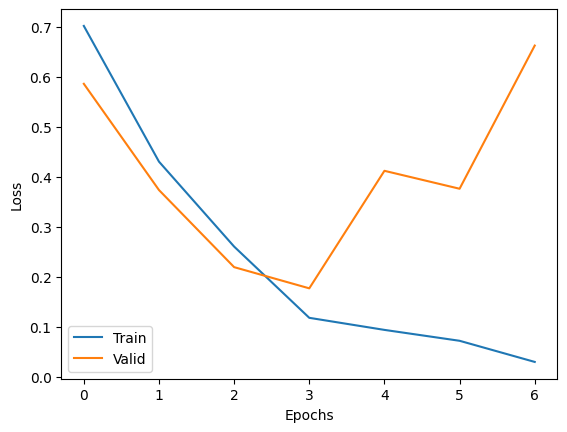

In [38]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/Best Model/RandomSearch/model.pt
Classification Report:
Real - Precision: 0.9673, Recall: 0.9159, F1-Score: 0.9409
Fake - Precision: 0.8430, Recall: 0.9358, F1-Score: 0.8870
Accuracy: 0.9223880597014925


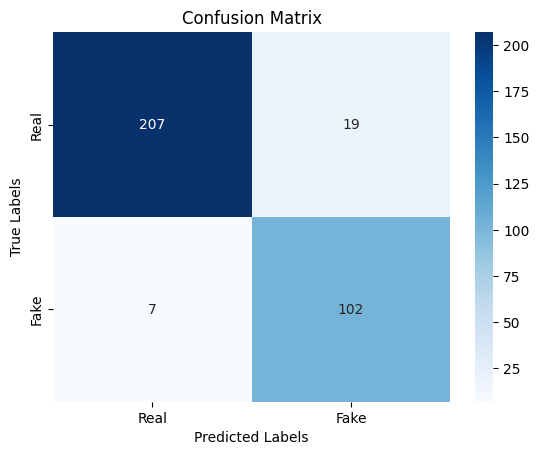

In [39]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning Random Search with Import Optuna

In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.8 MB/s eta 0:00:00


In [18]:
import optuna

# Define an objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 6, 7, 8, 9, 10])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model,
                                                                                  optimizer=optimizer,
                                                                                  criterion=criterion,
                                                                                  train_loader=train_iter,
                                                                                  valid_loader=valid_iter,
                                                                                  num_epochs=num_epochs,
                                                                                  eval_every=1,
                                                                                  file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],
        'valid_loss': valid_loss_list,
        'epoch_list': epoch_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }

    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')

    # Implement early stopping
    if len(valid_loss_list) >= 3:
        if best_valid_loss > results['best_valid_loss']:
            print("Validation loss hasn't improved in the last 3 epochs. Stopping early.")
            raise optuna.TrialPruned()

    return best_valid_loss

# Set up Optuna study with RandomSampler
sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective, n_trials=36)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-06-21 11:22:52,313] A new study created in memory with name: no-name-6ea72b1a-9cb3-461b-88ad-6a318b4e29ac
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.4281, Valid Loss: 0.2725
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.2324, Valid Loss: 0.2335
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.1483, Valid Loss: 0.2297
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.0989, Valid Loss: 0.2649
Epoch [5/7], Train Loss: 0.0576, Valid Loss: 0.3111
Epoch [6/7], Train Loss: 0.0289, Valid Loss: 0.5001
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!


[I 2023-06-21 11:24:55,327] Trial 0 finished with value: 0.22972964235980595 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 0 with value: 0.22972964235980595.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6729, Valid Loss: 0.6576
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.6551, Valid Loss: 0.6609
Epoch [3/6], Train Loss: 0.3520, Valid Loss: 0.2836
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.2030, Valid Loss: 0.2447
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/6], Train Loss: 0.1212, Valid Loss: 0.2201
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/6], Train Loss: 0.0921, Val

[I 2023-06-21 11:26:57,590] Trial 1 finished with value: 0.21118528143103635 and parameters: {'lr': 2e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 1 with value: 0.21118528143103635.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.4701, Valid Loss: 0.2788
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.2992, Valid Loss: 0.2893
Epoch [3/9], Train Loss: 0.1991, Valid Loss: 0.4476


[I 2023-06-21 11:28:12,673] Trial 2 pruned. 


Epoch [4/9], Train Loss: 0.1311, Valid Loss: 0.3290
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6134, Valid Loss: 0.5653
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.3171, Valid Loss: 0.2113
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.1745, Valid Loss: 0.2123
Epoch [4/10], Train Loss: 0.1062, Valid Loss: 0.1633
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.0701, Valid Loss: 0.1609
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/10], Train Loss: 0.037

[I 2023-06-21 11:30:54,179] Trial 3 finished with value: 0.1609072876162827 and parameters: {'lr': 3e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 3 with value: 0.1609072876162827.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6867, Valid Loss: 0.7039
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.6946, Valid Loss: 0.6795
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.6701, Valid Loss: 0.6494
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.6762, Valid Loss: 0.6712


[I 2023-06-21 11:32:32,494] Trial 4 pruned. 


Epoch [5/5], Train Loss: 0.6758, Valid Loss: 0.6790
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5706, Valid Loss: 0.4140
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.2691, Valid Loss: 0.2274
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.1208, Valid Loss: 0.3390
Epoch [4/5], Train Loss: 0.0665, Valid Loss: 0.1458
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/5], Train Loss: 0.0591, Valid Loss: 0.5682
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!


[I 2023-06-21 11:34:11,716] Trial 5 finished with value: 0.14577763767114707 and parameters: {'lr': 5e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 5 with value: 0.14577763767114707.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6610, Valid Loss: 0.6425
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.4471, Valid Loss: 0.3204
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.2447, Valid Loss: 0.2298
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1402, Valid Loss: 0.2080
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/9], Train Loss: 0.0743, Valid Loss: 0.1539
Model saved to ==> /content/drive/My

[I 2023-06-21 11:36:51,576] Trial 6 pruned. 


Epoch [8/9], Train Loss: 0.0087, Valid Loss: 0.3082
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6218, Valid Loss: 0.4403
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.2879, Valid Loss: 0.3238
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.1806, Valid Loss: 0.2227
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.1113, Valid Loss: 0.1614
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/7], Train Loss: 0.0662, Valid Loss: 0.1148
Model saved to ==> /content/drive/My

[I 2023-06-21 11:39:11,635] Trial 7 finished with value: 0.11477370491983103 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 7 with value: 0.11477370491983103.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6459, Valid Loss: 0.5949
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.3295, Valid Loss: 0.3231
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.1655, Valid Loss: 0.3372
Epoch [4/8], Train Loss: 0.1192, Valid Loss: 0.2416
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/8], Train Loss: 0.0430, Valid Loss: 0.1877
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/8], Train Loss: 0.0240, Val

[I 2023-06-21 11:41:48,283] Trial 8 pruned. 


Epoch [8/8], Train Loss: 0.0348, Valid Loss: 0.1797
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6453, Valid Loss: 0.6940
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.5794, Valid Loss: 0.4716
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2389, Valid Loss: 0.4776
Epoch [4/10], Train Loss: 0.1441, Valid Loss: 0.4306
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.0945, Valid Loss: 0.3421
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/10], Train Loss: 0.070

[I 2023-06-21 11:45:03,264] Trial 9 pruned. 


Epoch [10/10], Train Loss: 0.0013, Valid Loss: 0.1349
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6500, Valid Loss: 0.6596
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.7638, Valid Loss: 0.6725
Epoch [3/7], Train Loss: 0.6935, Valid Loss: 0.6761


[I 2023-06-21 11:46:18,349] Trial 10 pruned. 


Epoch [4/7], Train Loss: 0.6818, Valid Loss: 0.6632
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6502, Valid Loss: 0.6419
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.4066, Valid Loss: 0.3341
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.2761, Valid Loss: 0.3491
Epoch [4/5], Train Loss: 0.2075, Valid Loss: 0.2324
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt


[I 2023-06-21 11:47:55,755] Trial 11 pruned. 


Epoch [5/5], Train Loss: 0.2276, Valid Loss: 0.2592
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6787, Valid Loss: 0.6665
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.7036, Valid Loss: 0.6670
Epoch [3/9], Train Loss: 0.6982, Valid Loss: 0.6562
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.6811, Valid Loss: 0.6791
Epoch [5/9], Train Loss: 0.6695, Valid Loss: 0.6672
Epoch [6/9], Train Loss: 0.5342, Valid Loss: 0.5566
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [7/9], Train Loss: 0.6639, Valid Loss: 0.6879
Epoch [8/9], Train Loss: 0.6559, Valid Loss: 0.6651


[I 2023-06-21 11:50:44,622] Trial 12 pruned. 


Epoch [9/9], Train Loss: 0.6794, Valid Loss: 0.6566
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6842, Valid Loss: 0.6941
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.5763, Valid Loss: 0.5878
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.2958, Valid Loss: 0.3012
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.2215, Valid Loss: 0.2371
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/5], Train Loss: 0.1230, Valid Loss: 0.2328


[I 2023-06-21 11:52:26,259] Trial 13 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6562, Valid Loss: 0.6674
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.5459, Valid Loss: 0.3746
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.3383, Valid Loss: 0.3340
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.1916, Valid Loss: 0.7072


[I 2023-06-21 11:54:03,986] Trial 14 pruned. 


Epoch [5/5], Train Loss: 0.1343, Valid Loss: 0.3560
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6892, Valid Loss: 0.6677
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.5847, Valid Loss: 0.4295
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.3039, Valid Loss: 0.2440
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.2203, Valid Loss: 0.2830
Epoch [5/10], Train Loss: 0.1098, Valid Loss: 0.2054
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/10], Train Loss: 0.050

[I 2023-06-21 11:56:41,464] Trial 15 pruned. 


Epoch [8/10], Train Loss: 0.0276, Valid Loss: 0.7989
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6534, Valid Loss: 0.6827
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.6866, Valid Loss: 0.6717
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.5180, Valid Loss: 0.4516
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.2512, Valid Loss: 0.2698
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/6], Train Loss: 0.1901, Valid Loss: 0.2295
Model saved to ==> /content/drive/My

[I 2023-06-21 11:58:40,199] Trial 16 pruned. 


Epoch [6/6], Train Loss: 0.0992, Valid Loss: 0.2815
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6664, Valid Loss: 0.6456
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.5480, Valid Loss: 0.3606
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2806, Valid Loss: 0.2410
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.1842, Valid Loss: 0.2764
Epoch [5/10], Train Loss: 0.1015, Valid Loss: 0.3013
Epoch [6/10], Train Loss: 0.0560, Valid Loss: 0.1672
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/Model

[I 2023-06-21 12:01:30,978] Trial 17 pruned. 


Epoch [9/10], Train Loss: 0.0118, Valid Loss: 0.2232
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6513, Valid Loss: 0.6491
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.5185, Valid Loss: 0.2682
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.2203, Valid Loss: 0.1984
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/8], Train Loss: 0.1291, Valid Loss: 0.2178
Epoch [5/8], Train Loss: 0.0748, Valid Loss: 0.3101
Epoch [6/8], Train Loss: 0.0717, Valid Loss: 0.1701
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbala

[I 2023-06-21 12:04:04,000] Trial 18 pruned. 


Epoch [8/8], Train Loss: 0.0450, Valid Loss: 0.2246
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6226, Valid Loss: 0.4696
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.3487, Valid Loss: 0.1971
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.2250, Valid Loss: 0.1891
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.1314, Valid Loss: 0.2029
Epoch [5/7], Train Loss: 0.0894, Valid Loss: 0.1944


[I 2023-06-21 12:06:03,368] Trial 19 pruned. 


Epoch [6/7], Train Loss: 0.0933, Valid Loss: 0.2572
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5713, Valid Loss: 0.4007
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.4708, Valid Loss: 0.3193
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.2084, Valid Loss: 0.1583
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.1014, Valid Loss: 0.1511
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/5], Train Loss: 0.0715, Valid Loss: 0.1347


[I 2023-06-21 12:07:49,726] Trial 20 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6698, Valid Loss: 0.6968
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.6984, Valid Loss: 0.6740
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.7525, Valid Loss: 0.7539
Epoch [4/6], Train Loss: 0.6616, Valid Loss: 0.6619
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/6], Train Loss: 0.6850, Valid Loss: 0.6776


[I 2023-06-21 12:09:45,346] Trial 21 pruned. 


Epoch [6/6], Train Loss: 0.6486, Valid Loss: 0.7107
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6685, Valid Loss: 0.6542
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.6154, Valid Loss: 0.3983
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.3139, Valid Loss: 0.3778
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.2057, Valid Loss: 0.3150
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/7], Train Loss: 0.1104, Valid Loss: 0.2846
Model saved to ==> /content/drive/My

[I 2023-06-21 12:12:07,502] Trial 22 pruned. 


Epoch [7/7], Train Loss: 0.0533, Valid Loss: 0.2680
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6522, Valid Loss: 0.6847
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.5576, Valid Loss: 0.3418
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.2639, Valid Loss: 0.2298
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1375, Valid Loss: 0.2862
Epoch [5/9], Train Loss: 0.0762, Valid Loss: 0.3130
Epoch [6/9], Train Loss: 0.0610, Valid Loss: 0.1020
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbala

[I 2023-06-21 12:15:04,872] Trial 23 finished with value: 0.10199162546944406 and parameters: {'lr': 5e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 23 with value: 0.10199162546944406.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6477, Valid Loss: 0.6282
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.5036, Valid Loss: 0.3751
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.2324, Valid Loss: 0.2103
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1510, Valid Loss: 0.2923
Epoch [5/9], Train Loss: 0.0718, Valid Loss: 0.2716


[I 2023-06-21 12:17:00,294] Trial 24 pruned. 


Epoch [6/9], Train Loss: 0.0422, Valid Loss: 0.2722
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6525, Valid Loss: 0.6496
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.4354, Valid Loss: 0.3358
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.2096, Valid Loss: 0.1832
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.1611, Valid Loss: 0.2355
Epoch [5/7], Train Loss: 0.0736, Valid Loss: 0.1621
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/7], Train Loss: 0.0305, Val

[I 2023-06-21 12:19:18,128] Trial 25 pruned. 


Epoch [7/7], Train Loss: 0.0110, Valid Loss: 0.1814
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6342, Valid Loss: 0.6288
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.4348, Valid Loss: 0.2450
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.1787, Valid Loss: 0.3064
Epoch [4/9], Train Loss: 0.0995, Valid Loss: 0.5140
Epoch [5/9], Train Loss: 0.0810, Valid Loss: 0.2424
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/9], Train Loss: 0.0552, Valid Loss: 0.1293
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbala

[I 2023-06-21 12:22:09,544] Trial 26 pruned. 


Epoch [9/9], Train Loss: 0.0689, Valid Loss: 0.1632
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6730, Valid Loss: 0.6642
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.6719, Valid Loss: 0.6085
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.6476, Valid Loss: 0.6621
Epoch [4/8], Train Loss: 0.6482, Valid Loss: 0.7438


[I 2023-06-21 12:23:44,731] Trial 27 pruned. 


Epoch [5/8], Train Loss: 0.7008, Valid Loss: 0.6649
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6523, Valid Loss: 0.6804
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.6433, Valid Loss: 0.4266
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.3279, Valid Loss: 0.2461
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.2718, Valid Loss: 0.2673
Epoch [5/5], Train Loss: 0.0933, Valid Loss: 0.2326


[I 2023-06-21 12:25:25,673] Trial 28 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6243, Valid Loss: 0.6254
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.5023, Valid Loss: 0.6246
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.2177, Valid Loss: 0.3270
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/8], Train Loss: 0.1484, Valid Loss: 0.3655
Epoch [5/8], Train Loss: 0.0967, Valid Loss: 0.2578
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/8], Train Loss: 0.0617, Val

[I 2023-06-21 12:28:00,462] Trial 29 pruned. 


Epoch [8/8], Train Loss: 0.0196, Valid Loss: 0.2816
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6253, Valid Loss: 0.4694
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.2734, Valid Loss: 0.2352
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.1952, Valid Loss: 0.1853
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.0967, Valid Loss: 0.1647
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/9], Train Loss: 0.0773, Valid Loss: 0.1016
Model saved to ==> /content/drive/My

[I 2023-06-21 12:30:37,540] Trial 30 finished with value: 0.10157103929668665 and parameters: {'lr': 5e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 30 with value: 0.10157103929668665.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6620, Valid Loss: 0.6841
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.6883, Valid Loss: 0.7359
Epoch [3/7], Train Loss: 0.6846, Valid Loss: 0.7087


[I 2023-06-21 12:31:52,534] Trial 31 pruned. 


Epoch [4/7], Train Loss: 0.6993, Valid Loss: 0.7085
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6808, Valid Loss: 0.6289
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.6803, Valid Loss: 0.6537
Epoch [3/5], Train Loss: 0.4417, Valid Loss: 0.3807
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.2168, Valid Loss: 0.2252
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt


[I 2023-06-21 12:33:30,027] Trial 32 pruned. 


Epoch [5/5], Train Loss: 0.1074, Valid Loss: 0.2680
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6821, Valid Loss: 0.6910
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.6096, Valid Loss: 0.4556
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.2521, Valid Loss: 0.1980
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1960, Valid Loss: 0.2232
Epoch [5/9], Train Loss: 0.1142, Valid Loss: 0.2358


[I 2023-06-21 12:35:24,851] Trial 33 pruned. 


Epoch [6/9], Train Loss: 0.0624, Valid Loss: 0.3661
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6449, Valid Loss: 0.7461
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.3898, Valid Loss: 0.3209
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.2944, Valid Loss: 0.2360
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.1712, Valid Loss: 0.2040
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [5/6], Train Loss: 0.0869, Valid Loss: 0.1752
Model saved to ==> /content/drive/My

[I 2023-06-21 12:37:28,086] Trial 34 pruned. 


Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [6/6], Train Loss: 0.0417, Valid Loss: 0.1792
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6291, Valid Loss: 0.6393
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.4683, Valid Loss: 0.3360
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.1805, Valid Loss: 0.2118
Model saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.1044, Valid Loss: 0.2301
Epoch [5/7], Train Loss: 0.0547, Valid Loss: 0.3165


[I 2023-06-21 12:39:27,494] Trial 35 pruned. 


Epoch [6/7], Train Loss: 0.0226, Valid Loss: 0.2261
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.
Best model: lr=5e-05, num_epochs=9, batch_size=32
Best valid loss: 0.10157103929668665


Metrics loaded from <== /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/metrics.pt


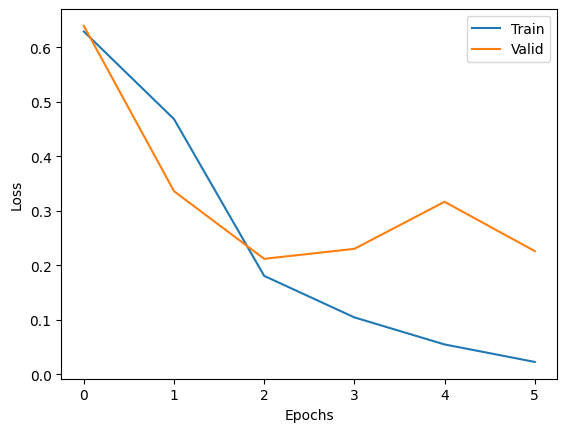

In [21]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/Random Search/ModelImbalance4/model.pt
Classification Report:
Real - Precision: 0.9541, Recall: 0.9204, F1-Score: 0.9369
Fake - Precision: 0.8462, Recall: 0.9083, F1-Score: 0.8761
Accuracy: 0.9164179104477612


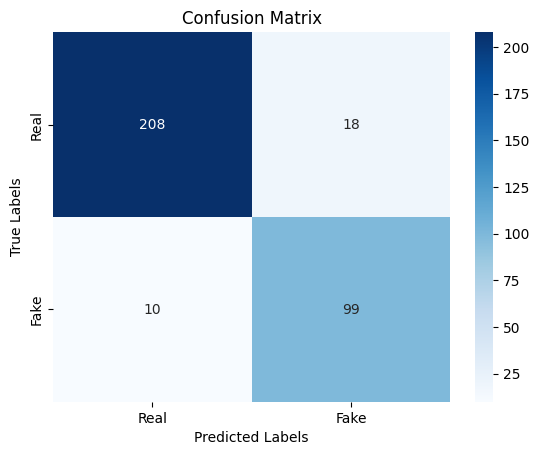

In [22]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)